# 깨달아야 하는 것?
* 머신러닝은 라이브러리가 제공된다. 머신러닝 자체가 어려운 작업은 아니다.
* 데이터를 어떻게 정제해서 학습할 데이터를 만드는지가 중요하다.
    * raw data를 어떻게 정제하고, feature engineering할 것인지
    

## Kaggle Titanic 예시
- 학습 : training data
- 제출 : test data

- 하다가 위에서부터 실행해야 할 때가 있다면, `Kernel` - `Restart and Run All`
- `logistic regression`의 경우는 `True`, `False`를 나누는 개념이기 때문에, 0, 1, 2 등으로 값을 변환한다고 해서 가중치 부여되거나, 선형으로 처리되거나 하는 것에 대해 신경쓰지 않아도 된다.

## 정확도 측정하면?

Kaggle에서 정확도 측정할 때 77% 정도가 최대
딥러닝을 이용하지 않으면, 그 이상으로 끌어올리기는 어렵다. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\ten

In [2]:
# training data load
train_df = pd.read_csv("./data/titanic/train.csv")
train_df.head()
print(train_df.corr())

# 총 몇 행 몇 열인지, 각 특성 별로 상세 정보 출력.
train_df.shape
train_df.info()
train_df.isnull().sum()     # 행 방향 : axis = 0(default) ,열 방향 : axis = 1



             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass    

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### data EDA

결측치와 이상치를 찾아서 적절한 값으로 변경하든가, 삭제하든가 처리해야 함.
그런데, 삭제하는 것은 유효한 데이터도 날릴 수 있기 때문에 **삭제는 지양.**
1. Age : 결측치 있음.
2. Cabin : 결측치 매우 많음 → 채운다고 하더라도 유용하지 않음.
3. 문자열을 숫자로 어떻게 변환할 것인가? 숫자 범위, 값의 할당, 변환 방법 등 고민.

### feature 선택
> 각 feature 간 상관관계를 판단할 때, data가 기반이 되어야 한다.
> 상식, 기존의 배경지식을 가지고 어떤 column이 영향을 미칠 것이라고 유추하는 것은 위험할 수 있다.

각 feature가 생존 여부에 영향을 미치는지 확인한다. 그런데, 상식, 내가 예측하는 것으로 보는 게 아니라, EDA를 통해 데이터로 확인해야 한다.
* 상관계수 계산 : 유용하지 않음.
* 각 column에 대해 파이 차트나 누적 막대 차트를 많이 이용.
    * 성별에 따른 생존, 사망 : 생존한 사람의 성별에 따른 사람 수, 사망한 사람의 성별에 따른 사람 수.
    * 선실 등급에 따른 생존, 사망 

feature가 많다고 좋은 것은 아님.
* 너무 많으면 과적합의 문제 발생.
* 필요 없는 것은 과감하게 날리고, 기존에 비슷한 column은 합치는 등의 작업이 필요하다.


In [3]:
# 결과적으로, 성별은 생존 여부에 영향을 미친다.

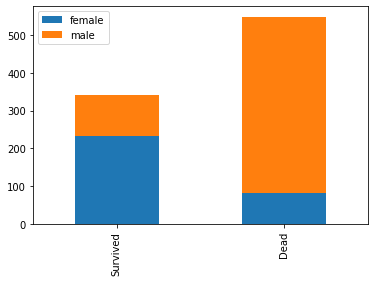

In [4]:
# 생존한 사람의 성별에 따른 사람 수
survived = train_df.loc[train_df["Survived"]==1]["Sex"].value_counts()   # Series로 나옴.
# 생존 인원 : 342명. -> 그 중에서 필요한 정보는 성별. -> 성별 구분별로 몇 명인지 확인.
# 현재 만든 series의 이름을 바꿈. 
survived.name = "Survived"
survived

# 사망한 사람의 성별에 따라서도 같은 작업 반복
dead = train_df.loc[train_df["Survived"]==0]["Sex"].value_counts()
dead.name = "Dead"
dead

# 두 개의 series를 데이터 프레임으로 만듦.
sex_df = pd.DataFrame([survived, dead])
sex_df
sex_df.plot(kind = "bar", stacked = True)

In [5]:
# 결과적으로, 선실 등급도 생존에 영향을 미친다.

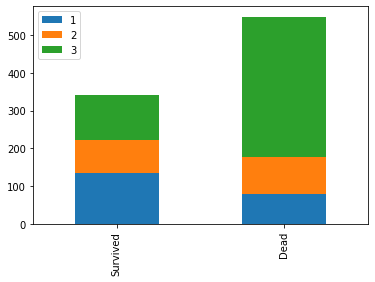

In [6]:
# 생존한 사람의 성별에 따른 사람 수
survived = train_df.loc[train_df["Survived"]==1]["Pclass"].value_counts()   # Series로 나옴.
# 생존 인원 : 342명. -> 그 중에서 필요한 정보는 성별. -> 성별 구분별로 몇 명인지 확인.
# 현재 만든 series의 이름을 바꿈. 
survived.name = "Survived"
survived

# 사망한 사람의 성별에 따라서도 같은 작업 반복
dead = train_df.loc[train_df["Survived"]==0]["Pclass"].value_counts()
dead.name = "Dead"
dead

# 두 개의 series를 데이터 프레임으로 만듦.
sex_df = pd.DataFrame([survived, dead])
sex_df
sex_df.plot(kind = "bar", stacked = True)

#### 모든 column에 대해 수작업할 수 없으므로, 함수 만들어 처리.
* 지금 그래프를 그리기에는 이름, 나이는 유의미한 그래프를 얻을 수 없을 것이라 생각되므로, 그것을 제외하고 그래프 그리기.

In [7]:
def stackedBarChart(feature):
    survived = train_df.loc[train_df["Survived"]==1][feature].value_counts()   
    survived.name = "Survived"
    survived
    dead = train_df.loc[train_df["Survived"]==0][feature].value_counts()
    dead.name = "Dead"
    dead
    sex_df = pd.DataFrame([survived, dead])
    sex_df
    sex_df.plot(kind = "bar", stacked = True)
    return

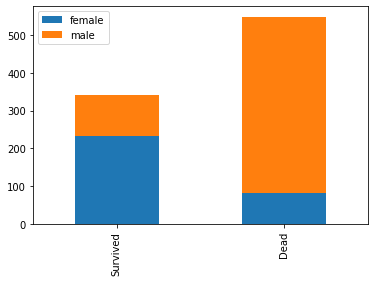

In [8]:
stackedBarChart("Sex")
# 성별은 영향을 미치는 것으로 보이므로, 살려야 한다.

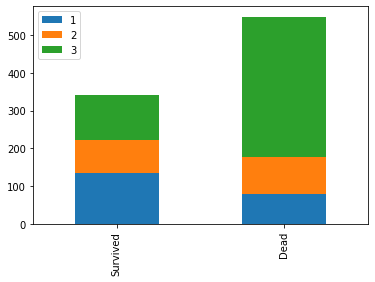

In [9]:
stackedBarChart("Pclass")
# 3등석에 탔을 때 사망한 비율이 더 높음.
# 3등석일수록 뭔가 뒤쪽이든지,

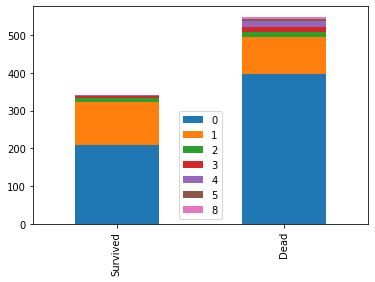

In [10]:
stackedBarChart("SibSp")
# 혼자 탄 사람이 dead에서 차지하는 비중이 더 큼.
# 의미가 없다고 볼 수는 없지 않을까?

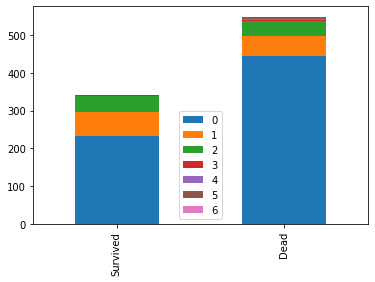

In [11]:
stackedBarChart("Parch")
# 부모나 자식과 같이 탄 사람의 생존 확률이 더 높지 않을까?

In [12]:
# 형제자매, 배우자, 부모, 자식 등 모두 다 가족 여부로 묶어보는 게 더 정확할 것이라 보인다.
# 

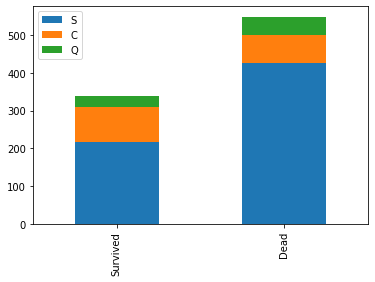

In [13]:
stackedBarChart("Embarked")
# Embarked도 관련이 있을 것이라 보임.
# 승선한 항구에 대해서, S에서 타면 사망한 비율이 높음. 뭔가 더 돈이 없었거나, 뒤에 위치했거나 등.

### Feature Engineering
> - **매우 중요** : feature engineering 결과에 따라 학습의 결과가 달라진다.
> - 각 feature를 학습에 적합한 형태로 modeling! 각 `feature`별로 의미가 있는지 알아보고, 새로운 feature 만들고 학습시킬 수 있는 형태로 만들어 낸다.

1. Text: 문자열은 머신러닝 학습에 적절하지 않으므로, 숫자 형태로 전환. ex) Name, Sex, Embarked, ..
    * ticket 번호는 생존여부와 관계가 없어 보이므로, 제외.
    * cabin은 결측치가 과도하게 많기 때문에, 제외.
2. Scale : 각 feature마다 scale 차이가 크다면, 학습에 불리함.
    * 각 column이 비슷한 범위로 조절되어야 함.
    * 애초에 engineering 단계에서 비슷한 범위로 맞춰주어야 함.
    * 나중에 `MinMaxScaler()` 활용.
3. 결측치 : `NaN`(결측치)는 적절한 scale의 숫자로 대체.
    * Name 이용해 결측치 fill.
4. 의미를 찾을 수 없는 열은 `drop`.
5. 이상치 : 원래는 이상치 제거해야 하나, 이 예제에서는 고려하지 않음.

##### Name
* 가장 먼저 해결해야 할 feature.
* 그 자체로 큰 의미는 없지만, 이름 안의 호칭을 이용해 생존에 영향을 미치는지 확인할 수 있음.
* **정규표현식** 이용해 해당 부분만 추출할 수 있음.
* 추출한 이후, 크기에 따라 어느 호칭까지 남길 것인지 결정. (강사님은 title 안에 mr, miss, mrs, other를 0, 1, 2, 3으로 변환.)
* 변환하기 위해 series의 **map** 기능 이용
* 이름을 변환한 호칭 feature가 실제로 생존에 영향을 미치는지 알아보기 위해 그래프 생성.

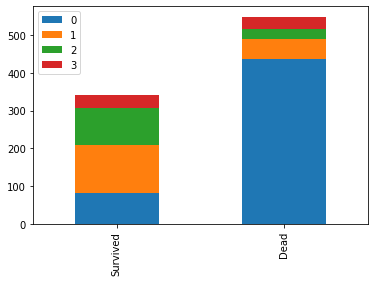

In [14]:
train_df["Title"] = train_df["Name"].str.extract("([A-Za-z]+)\.")
train_df["Title"].value_counts()
# "Name" series에서 문자열만 추출.
# 추출할 패턴으로 정규표현식 사용.
# ([A-Za-z]+) : 영문자 대소문자 개수 상관없이 다 나와도 됨.
# - [] : 대괄호는 글자 1개 나온다는 것을 의미.
# - A-Za-Z : 영문자로 대소문자가 다 들어가 있음.
# - + : 1개 이상. 
# - \. : period를 기호(문자)로서 쓰고 싶을 때는 escape 필요.
# ([A-Za-z]+)\. : 영문자 대소문자 개수 상관없이 나오고, period.

title_mapping_dict = {"Mr" : 0, 
                      "Miss" : 1, "Ms" :1,
                      "Mrs" : 2, 
                      "Master" : 3, "Dr": 3, "Rev" : 3, "Col" : 3, "Mlle" : 3, "Major" : 3, "Capt" : 3, "Sir" : 3, "Countess" : 3, "Mme" : 3, "Don" : 3, "Jonkheer" : 3, "Lady" : 3}
train_df["Title"] = train_df["Title"].map(title_mapping_dict)
# dictionary 만들고, series의 map 함수를 이용해 각 함수의 값을 변환한다.

stackedBarChart("Title")
# 새로운 feature를 통해 확인해 보니, 호칭별로 생존에 차이가 발생한다.


In [15]:
# 필요 없는 feature 날리기
# 열 방향이니까, axis = 1

# 이름, 티켓 번호는 의미를 찾을 수 없다.
train_df.drop("Name", axis = 1, inplace = True)
train_df.drop("Ticket", axis = 1, inplace = True)

# cabin은 결측치가 너무 많다.
train_df.drop("Cabin", axis = 1, inplace = True)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,0
1,2,1,1,female,38.0,1,0,71.2833,C,2
2,3,1,3,female,26.0,0,0,7.9250,S,1
3,4,1,1,female,35.0,1,0,53.1000,S,2
4,5,0,3,male,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,3
887,888,1,1,female,19.0,0,0,30.0000,S,1
888,889,0,3,female,NaN,1,2,23.4500,S,1
889,890,1,1,male,26.0,0,0,30.0000,C,0


##### Sex
* 문자열 column이므로 바꿔주어야 함. male = 0, female = 1.
    * dictionary, map 이용.
* 결측치 없으므로 바로 처리 가능.

In [16]:
sex_mapping_dict = {"male" : 0, "female" : 1}
train_df["Sex"] = train_df["Sex"].map(sex_mapping_dict)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,0,22.0,1,0,7.2500,S,0
1,2,1,1,1,38.0,1,0,71.2833,C,2
2,3,1,3,1,26.0,0,0,7.9250,S,1
3,4,1,1,1,35.0,1,0,53.1000,S,2
4,5,0,3,0,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,S,3
887,888,1,1,1,19.0,0,0,30.0000,S,1
888,889,0,3,1,NaN,1,2,23.4500,S,1
889,890,1,1,0,26.0,0,0,30.0000,C,0


##### Embarked
* 문자열 column이므로 바꿔주어야 함. male = 0, female = 1.
* 결측치 2개 있음 : 먼저 결측치 처리하지 않으면 문제 발생.
* 가중치는 중요하게 고려하지 않아도 될 것 같은 자료 구조.

In [17]:
# # 결측치 처리하지 않았을 때의 문제점
# # NaN은 실수처리되기 때문에, 0, 1, 2가 실수로서 0.0, 2.0, ... 이런 방식으로 나옴.
# embarked_mapping_dict = {"S" : 0, "Q" : 1, "C" : 2}
# train_df["Embarked"] = train_df["Embarked"].map(embarked_mapping_dict)
# train_df

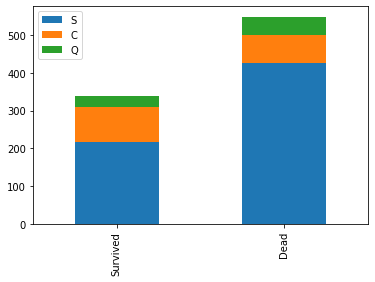

In [18]:
# 결측치 처리.
# 지우거나, 가장 많이 탄 지역으로 넣거나, 등.
stackedBarChart("Embarked")                        # S지역에서 많이 탄 것을 알 수 있다.
train_df["Embarked"].fillna("S", inplace = True)
embarked_mapping_dict = {"S" : 0, "Q" : 1, "C" : 2}
train_df["Embarked"] = train_df["Embarked"].map(embarked_mapping_dict)

##### Age
* 결측치가 많으므로, 가능한 한 타당한 방식으로 결측치를 채워야 함.
    * 전체 나이 평균 구해서 넣는 방법.
    * *title을 이용해 호칭별 나이 평균 구해서 넣는 방법.*
    * ...
* Binning : Age 범위가 제각각이므로 학습 어렵기 때문에, Age의 범위를 구간으로 나눠서 구간별로 숫자 mapping.
    * Binning시 간격을 어떻게 설정할지 고려해야 함.
    * naive한 방법 -> 20이하 : 0, 20 초과 40 미만 : 1, 40 이상 60 미만 : 2, 60 초과 : 3
    * 빈도를 확인하고 빈도별로 구간을 설정해야 가장 합리적.
* Binning 후 그래프 확인을 통해 생사 여부에 관련 있는지 확인.

In [19]:
# 나이 평균 구하기 내가 한 방법
train_df[["Title", "Age"]].groupby("Title").mean()

,Age
Title,
0,32.368090
1,21.816327
2,35.898148
3,20.306066


In [20]:
# 1) 각 호칭별 나이 평균을 통해 결측치 채우기.
# 나이 평균 구하기 강사님 방법

# 일단 호칭별로 나이 평균 구하기
age_mean = train_df.groupby("Title")["Age"].mean()              # 자료구조 : series
age_mean

# 호칭이 Mr(0)인 행들에 대한 age만 들고 오고, na값을 채워넣는다.
a = train_df[train_df["Title"]==0]["Age"].fillna(age_mean[0])   # mr그룹에 대한 결측값 채우기 : series
b = train_df[train_df["Title"]==1]["Age"].fillna(age_mean[1])
c = train_df[train_df["Title"]==2]["Age"].fillna(age_mean[2])
d = train_df[train_df["Title"]==3]["Age"].fillna(age_mean[3])

# concatenate 이용해서 series 합치기
result = pd.concat([a,b,c,d])
result                                                          # index가 중구난방으로 나옴.
result.sort_index()

# age 열을 바꿈.
train_df["Age"] = result.sort_index()
train_df
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

In [21]:
# 2) 나이 구간별로 나눠주기.
# 강사님 방법으로 Binning
train_df.loc[train_df["Age"] <= 20, "Age"] = 0          # Age 20 이하인 행들, 그 행의 Age를 0으로.
train_df.loc[(train_df["Age"] > 20) & (train_df["Age"] <= 40), "Age"] = 1
train_df.loc[(train_df["Age"] > 40) & (train_df["Age"] <= 60), "Age"] = 2
train_df.loc[train_df["Age"] > 60, "Age"] = 3
train_df["Age"].value_counts()

1.0    562
0.0    179
2.0    128
3.0     22
Name: Age, dtype: int64

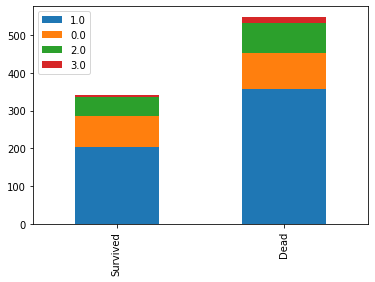

In [22]:
stackedBarChart("Age")
# 나이도 학습 시 연관이 있음.

##### SibSp + Parch = Family

##### Fare
* 요금 범위가 너무 크기 때문에, 학습에 불리하다.
* Binning : 적절하게 구간을 나누어, 학습에 용이하게 바꾼다.

In [23]:
# 내가 binning 진행한 방법
# train_df["Fare"].min() # 0
# train_df["Fare"].max() # 512.3292
# train_df["Fare"] = pd.qcut(train_df["Fare"], 4, labels=[0, 1, 2, 3])
# train_df["Fare"].value_counts()

In [24]:
# 강사님 방법 : naive하게 , 균등하게 진행했다.
train_df.loc[train_df["Fare"] <= 100, "Fare"] = 0          # Age 20 이하인 행들, 그 행의 Age를 0으로.
train_df.loc[(train_df["Fare"] > 100) & (train_df["Fare"] <= 200), "Fare"] = 1
train_df.loc[(train_df["Fare"] > 200) & (train_df["Fare"] <= 300), "Fare"] = 2
train_df.loc[train_df["Fare"] > 300, "Fare"] = 3
train_df["Fare"].value_counts()

0.0    838
1.0     33
2.0     17
3.0      3
Name: Fare, dtype: int64

In [25]:
# 머신러닝 들어가기 전에 PassengerId drop
train_df.drop("PassengerId", axis = 1, inplace = True)
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1.0,1,0,0.0,0,0
1,1,1,1,1.0,1,0,0.0,2,2
2,1,3,1,1.0,0,0,0.0,0,1
3,1,1,1,1.0,1,0,0.0,0,2
4,0,3,0,1.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1.0,0,0,0.0,0,3
887,1,1,1,0.0,0,0,0.0,0,1
888,0,3,1,1.0,1,2,0.0,0,1
889,1,1,0,1.0,0,0,0.0,2,0


## 머신러닝 진행
`Tensorflow` 통해 머신러닝 구현


1. 필요한 library 로딩

In [26]:
import tensorflow as tf

2. data set 준비
> * logistic regression부터는, 모델의 정확도를 측정하기 위해 학습용, 평가용으로 데이터를 분리해야 한다. 
> * 단, Kaggle에서 제공하는 test data는 제출용으로 사용해야 하는 것이므로, 지금 가지고 있는 train_df를 나누어 학습용 데이터와 평가용 데이터를 생성해야 한다.

* 일반적으로 7:3, 8:2 정도의 비율로 나눈다.
    * data의 편향이 발생할 수 있어서, 어떻게 나누는가에 따라 결과가 다를 수 있다.(손필기)
    * 어떻게 학습용과 평가을 나누는지가 중요하다.
* n fold Corss Validation : `교차 검증`(손필기)
    * n : 정수, data를 몇 개로 쪼갤 것인가.
    * 교차 : n개씩 나누고, 각각의 경우에 대해 평가용 data를 한 번씩 바꾼다.
    * n개의 정확도 : 각각의 경우에 대해 정확도1, 정확도2, ..., 정확도n.
    * 정확도 도출 : n개의 정확도의 평균을 도출한다.

In [27]:
# 이 예제에서는, 상위 80%를 학습용 데이터로, 하위 20%를 평가용 데이터로 사용.
# n fold 방식으로 하려면, 학습용, 평가용 데이터 셋을 구하는 과정을 loop를 돌려야 한다.

# 2- 1) train data의 shape 확인
train_df.shape

# 2- 2) 학습용, 테스트용 data의 개수 구하기
train_num = int(train_df.shape[0] * 0.8)         # shape(tuple)의 첫 번째 원소 : 행. -> 실수니까, int 씌우기.
# 712개: 위에서부터 712개, 즉, 0번째부터 711번째까지가 학습용 data.
test_num = train_df.shape[0] - train_num

# 2- 3) 학습용 data set 생성
# 일단 data frame에서 해당하는 것 들고오고,
# 머신러닝에서는 실제 data frame이 아니라 그 안의 값만 필요하므로 numpy array 만들어준다.

# 2- 3)-1)). 학습을 하기 위해 x 자리에 들어갈 x_data
train_x_data = train_df.drop("Survived", axis = 1, inplace = False)[:train_num].values
# survived 지우는데, 행이 아니라 열을 지워야 하므로, 열 방향(axis = 1)이라고 명시.
# inplace = False : 원본 변하지 않고 처리된 결과를 얻어내야 함.
# 행을 뽑아오는데, 상위 712개.
# values를 통해 numpy array로 만들어줘야 함.

# 2-3)-2)). 학습을 하기 위해 y 자리에 들어갈 label.
train_y_data = train_df["Survived"][:train_num].values.reshape([-1, 1])
# train_y_data = train_df["Survived"][:train_num].values : 여기까지만 하면 series가 나옴.
# reshape([-1,1]) : 2차원 형태의 numpy array로 만듦.

# 2-4) 테스트용 data set 생성
# 2-4)- 1)). 테스트를 하기 위해 x 자리에 들어갈 x_data
test_x_data = train_df.drop("Survived", axis = 1, inplace = False)[train_num:].values
# 2-4)- 2)). 테스트를 하기 위해 y 자리에 들어갈 y_data
test_y_data = train_df["Survived"][train_num:].values.reshape([-1, 1])

3. 머신러닝
> Tensorflow를 이용한 Logistic Regression Code

In [28]:
# 3-1) placeholder
# 입력 데이터 받아들이는 parameter

train_x_data.shape
train_y_data.shape
X = tf.placeholder(shape = [None, 8], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 1], dtype = tf.float32)

# 3-2) weight, bias
# 아직가지는 Random으로 잡지만, random이 그다지 좋은 방법이아니다.
# 딥러닝 가면 random이 아니다.
# 원래는 이름 지정해주지 않아도 되는데, 나중에 내부적으로 그래프에서 이름이 겹칠 수도 있으니까 지정.

W = tf.Variable(tf.random_normal([8,1]), name = "weight")
b = tf.Variable(tf.random_normal([1]), name = "bias")

# 3-3) hypothesis
# linear : H = tf.matmul(X, W) + b
# logistic에서는 logit을 만들고, 그것을 sigmoid에 넣는다.
logit = tf.matmul(X,W) + b
H = tf.sigmoid(logit)

# 3-4) cost(loss) function
# linear : 최소제곱법 이용
# logistic : 최소제곱법 이용하면 local minimum 구하게 될 수도 있음. 따라서, sigmoid_cross_entropy 사용.
# 인자 : logits, labels
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit,
                                                              labels = Y))

# 3-5) train 
# gradient descent 알고리즘 사용해서 cost function 줄여가기.
# learning_rate : 0.01부터 시작해서 줄여가면서 찾기.
# 학습의 한 단계 : cost를 최소화시켜 나간다.
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
train = optimizer.minimize(cost)

# 3-6) session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 3-7) 학습 진행
# placeholder 사용하고 있기 때문에, X 값, Y 값에 뭘 넣을지 feed 필요함.
# range 30000, learning_rate 0.01 -> 마지막 cost 값은 : 0.43668675422668457.
# 학습을 많이 할수록 유리하긴 하지만, 아무리 많이 해도 떨어지지 않음. 적절한 학습 횟수 있음.
# range 30000, learning_rate 0.001 -> 마지막 cost 값은 : 0.4803159832954407

for step in range(30000):
    _, cost_val = sess.run([train, cost],
                          feed_dict = {X : train_x_data,
                                      Y: train_y_data})
    if step % 3000 == 0:
        print("cost 값은 : {}".format(cost_val))

# 3-8) 학습 완료
# 최적의 W, b를 구했다는 의미 = 모델을 구성하는 데에 성공.

# 3-9) 정확도 측정
# 제대로 모델을 만들었는지 확인하기 위해 테스트용 x 입력데이터(test_x_data)를 넣어서 예측.
# 구한 예측값과 이미 가지고 있는 테스트용 y 입력데이터(test_y_data)를 비교.
# 동일하다면, 모델이 잘 만들어진 것.
# 예측값과 테스트용 y 입력데이터가 얼마나 다른지에 대한 비율을 "코드로" 구현하는 과정.
# tensorflow 기능 이용해서 알아낼 것.

# 예측값 구하기
# logistic은 0과 1 사이의 실수, 즉, 확률값으로 결과가 도출된다.
# ex) 0.6 : 1에 가까울 확률이 60%.
# 따라서 기준점을 잡아야 한다. 얼마나 나와야 1에 가깝다고 간주할 것인가?
# 통상, 0.5를 기준으로 잡는다. 다만, 정해져 있는 것은 아니다.

predict = tf.cast(H > 0.5, dtype = tf.float32)
# tensorflow가 가진 cast라는 함수
# 비교가 안 되니까, cast를 이용해서 기준값을 잡아줌.
# True, False를 판별할 기준 : H > 0.5
# True가 떨어지면 실수(float32)값으로 cast해라. -> 1.
# False가 떨어졌을 때 실수값으로 cast해라. -> 0.

correct = tf.equal(predict, Y)
# equal : tensorflow가 가지고 있는 비교하는 함수.
# 예측값(predict)과, Y를 비교해라,
# 둘 다 맞으면, 11이면 true, 00이면 true, 다르면 10이거나 01이거나 false.

accuracy = tf.reduce_mean(tf.cast(correct, dtype= tf.float32))
# boolean 값이 떨어지기 때문에, 그 boolean을 실수 형태로 바꾼 후 비율 구해준다.
# correct에서 구한 true, false 등 boolean값의 dtype이 실수형태로 바뀜.

print("정확도 : {}".format(sess.run(accuracy, feed_dict = {X : test_x_data,
                                                       Y : test_y_data})))
# accuracy 실행해줘야 함.

# 실행할 때마다 초기값이 random으로 잡히니까, 정확도, cost값이 달라짐.
# 정확도 대부분, 0.83 정도에서 나온다.

cost 값은 : 4.312685012817383
cost 값은 : 0.4875856935977936
cost 값은 : 0.4501290023326874
cost 값은 : 0.4402802586555481
cost 값은 : 0.4377741813659668
cost 값은 : 0.4370478093624115
cost 값은 : 0.4367823600769043
cost 값은 : 0.43665647506713867
cost 값은 : 0.43658313155174255
cost 값은 : 0.4365357756614685
정확도 : 0.8379888534545898


## 정리
1. 1차원적 logistic regression했을 때, 이 수준의 정확도로 학습을 시킬 수 있다.
2. 정리하면, 자체적으로 train data를 8:2의 비율로 나눠서 80% 학습시키고, 나머지 20% 정도를 가지고 테스트.
3. 도출된 정확도가 83%로, 만족스럽지는 않지만, layer가 하나여서, 딥러닝을 하지 않은 이상 더 상승시키기 어려움.

## 제출
Kaggle에서 제공한 test.csv 파일을 이용해서, prediction을 진행해야 함.
* train.csv와 동일하게 raw data이므로, 전처리 등 모든 작업 동일하게 진행하고, 학습 가능한 형태로 만들어야 함.
* 예측 결과가 나올텐데, 그것을 파일로 만들어서 제출하면, Kaggle 서버에서 정확도를 이용해 채점함.

## test.csv 파일 제출용

In [29]:
test_df = pd.read_csv("./data/titanic/test.csv")
test_df.head()
test_df.shape
test_df.info()
test_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Feature Engineering
1. PassengerId : 학습할 때는 필요하지 않으므로 drop.
2. Pclass : 경향성 상관 있으므로 남겨야 한다.
2. Name : Class 뽑아 내고, name 열 자체는 drop.
3. Sex : 숫자형태로 바꾸기(male = 0, female = 1)
4. Age : Class feasture 이용해서 결측치 채우기 + 20/20~40/40~60/60~ binning
5. SibSp, Parch : 원래는 Family로 합치는 게 낫지 않을까 싶지만, 우리가 예제로 할때는 그냥 놔뒀다.
6. Ticket : 의미 찾아낼 수 없으므로, drop
7. Fare : 100, 200, 300 구간 나누어서 binning
8. Cabin : 결측치 많으므로, drop
9. Embarked : 어디서 탔는지가 영향을 미쳤으므로, 남겨 놓는다.

In [30]:
# Name -> Class 뽑아 내기
test_df["Title"] = test_df["Name"].str.extract("([A-Za-z]+)\.")
test_df["Title"].value_counts()

title_mapping_dict = {"Mr" : 0,
                     "Miss" : 1, "Ms" : 1,
                     "Mrs" : 2,
                     "Master" : 3, "Col" : 3, "Rev" : 3, "Dona" : 3, "Dr" : 3}
test_df["Title"] = test_df["Title"].map(title_mapping_dict)
test_df["Title"].value_counts()

0    240
1     79
2     72
3     27
Name: Title, dtype: int64

In [31]:
# 필요 없는 열 drop
test_df.drop("Name", axis = 1, inplace = True)
test_df.drop("Ticket", axis = 1, inplace = True)
test_df.drop("Cabin", axis = 1, inplace = True)
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,0
1,893,3,female,47.0,1,0,7.0000,S,2
2,894,2,male,62.0,0,0,9.6875,Q,0
3,895,3,male,27.0,0,0,8.6625,S,0
4,896,3,female,22.0,1,1,12.2875,S,2
...,...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S,0
414,1306,1,female,39.0,0,0,108.9000,C,3
415,1307,3,male,38.5,0,0,7.2500,S,0
416,1308,3,male,NaN,0,0,8.0500,S,0


In [32]:
# Sex -> 숫자 형태로 바꾸기
test_df["Sex"]
sex_mapping_dict = {"male" : 0,
                   "female" : 1}
test_df["Sex"] = test_df["Sex"].map(sex_mapping_dict)
test_df["Sex"].value_counts()

0    266
1    152
Name: Sex, dtype: int64

In [33]:
# Age -> 결측치 채우기 -> binning
# 호칭별 나이 평균
age_mean = test_df.groupby("Title")["Age"].mean()
display(age_mean)

a = test_df[test_df["Title"] == 0]["Age"].fillna(age_mean[0])
b = test_df[test_df["Title"] == 1]["Age"].fillna(age_mean[1])
c = test_df[test_df["Title"] == 2]["Age"].fillna(age_mean[2])
d = test_df[test_df["Title"] == 3]["Age"].fillna(age_mean[3])

result = pd.concat([a,b,c,d])
result
result.sort_index()

test_df["Age"] = result.sort_index()
test_df.isnull().sum()

test_df.loc[test_df["Age"]<=20, "Age"] = 0

# binning 

test_df.loc[test_df["Age"]<=20, "Age"] = 0
test_df.loc[(test_df["Age"]>20) & (test_df["Age"]<=40), "Age"] = 1
test_df.loc[(test_df["Age"]>40) & (test_df["Age"]<=60), "Age"] = 2
test_df.loc[test_df["Age"]>60, "Age"] = 3
test_df["Age"].value_counts()

display(test_df)

Title
0    32.000000
1    21.774844
2    38.903226
3    16.909130
Name: Age, dtype: float64

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,1.0,0,0,7.8292,Q,0
1,893,3,1,2.0,1,0,7.0000,S,2
2,894,2,0,3.0,0,0,9.6875,Q,0
3,895,3,0,1.0,0,0,8.6625,S,0
4,896,3,1,1.0,1,1,12.2875,S,2
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1.0,0,0,8.0500,S,0
414,1306,1,1,1.0,0,0,108.9000,C,3
415,1307,3,0,1.0,0,0,7.2500,S,0
416,1308,3,0,1.0,0,0,8.0500,S,0


In [34]:
# Fare

# 결측치 채우기

fare_mean = test_df["Fare"].mean()
test_df["Fare"] = test_df["Fare"].fillna(fare_mean)

test_df.isnull().sum()
print(test_df["Fare"].min())
print(test_df["Fare"].max())

0.0
512.3292


In [35]:
# 구간 나눠서 binning

test_df.loc[test_df["Fare"]<=100, "Fare"] = 0
test_df.loc[(test_df["Fare"]>100) & (test_df["Fare"]<=200), "Fare"] = 1
test_df.loc[(test_df["Fare"]>200) & (test_df["Fare"]<=300), "Fare"] = 2
test_df.loc[test_df["Fare"]>300, "Fare"] = 3


display(test_df)
test_df["Fare"].value_counts()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,1.0,0,0,0.0,Q,0
1,893,3,1,2.0,1,0,0.0,S,2
2,894,2,0,3.0,0,0,0.0,Q,0
3,895,3,0,1.0,0,0,0.0,S,0
4,896,3,1,1.0,1,1,0.0,S,2
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1.0,0,0,0.0,S,0
414,1306,1,1,1.0,0,0,1.0,C,3
415,1307,3,0,1.0,0,0,0.0,S,0
416,1308,3,0,1.0,0,0,0.0,S,0


0.0    387
2.0     17
1.0     13
3.0      1
Name: Fare, dtype: int64

In [36]:
# embarked
embarked_mapping_dict = {"S": 0, 
                         "Q": 1, 
                         "C": 2}
test_df["Embarked"] = test_df["Embarked"].map(embarked_mapping_dict)

In [37]:
display(test_df)
test_df.isnull().sum()
test_df.info()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,1.0,0,0,0.0,1,0
1,893,3,1,2.0,1,0,0.0,0,2
2,894,2,0,3.0,0,0,0.0,1,0
3,895,3,0,1.0,0,0,0.0,0,0
4,896,3,1,1.0,1,1,0.0,0,2
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1.0,0,0,0.0,0,0
414,1306,1,1,1.0,0,0,1.0,2,3
415,1307,3,0,1.0,0,0,0.0,0,0
416,1308,3,0,1.0,0,0,0.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null int64
Title          418 non-null int64
dtypes: float64(2), int64(7)
memory usage: 29.5 KB


In [44]:
# 예측을 하기 위해 x 자리에 들어갈 x_data
predict_x_data = test_df.drop("PassengerId", axis = 1, inplace = False).values
predict_x_data

predict_test = tf.cast(H > 0.5, dtype = tf.float32)
result = sess.run(predict_test, feed_dict = {X : predict_x_data})
result = pd.DataFrame(result)
result

,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
413,0.0
414,1.0
415,0.0
416,0.0


In [50]:
# gender_submission 파일 불러오기
submit_df = pd.read_csv("./data/titanic/gender_submission.csv")
display(submit_df)
submit_df["Survived"] = result
submit_df = pd.DataFrame(submit_df, dtype = 'int32')

submit_df.to_csv("./data/titanic/submission_final_final.csv",
                 sep = ",",
                 header = True,
                 index = False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [40]:
# 아래는, 생각해볼 부분.

In [41]:
# column 이름 list에 넣어서 for문 돌려야 합니다!

# train_df.columns
# len(train_df.columns)
# for i in range(len(train_df.columns)):
#     stackedBarChart(train_df[i])

* Q) feature 그래프 확인할 때 비율로는 확인할 수 없나???
* Q) 그래프 한 번에 그릴 수 있게?
* Q) 나이 결측값 채울 때, 호칭으로 하려면 master도 빼줘야 하지 않나?
* Q) Age 결측값 binning 빈도별로?
* Q) 애초에 test.csv 파일도 한 번에 처음부터 전처리 진행하고, 표 나누면 되지 않나?????
* Q) Pclass가 rank마냥 반대로 가야 하지 않나?